# Dog Breed Classification using Softmax

## Used less iterations to save time

### Imports

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math

%matplotlib inline

### Directory

In [3]:
DATADIR = "C:/Dataset/Softmax/"
CATEGORIES = ["Beagle", "Bernese", "Boxer", "Chihuahua", "Chow",
              "Dingo","Doberman", "French_Bulldog", "German","Great_Dane",
              "Husky", "Lab", "Lhasa", "Malamute", "Pomerian",
              "Poodle", "Pug", "Rottweiler", "Samoyed", "Shi_Tsu"]
img_size = 64

### Loading Dataset

In [4]:
data = []

def load_data():
    for category in CATEGORIES:
        
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array,(img_size,img_size))
            data.append([new_array, class_num])

In [5]:
load_data()
print("No. of images: " + str(len(data)))
random.shuffle(data)

No. of images: 7136


### Sorting Data and Labels

In [6]:
X = []
y_unsorted = []

for features, label in data:
    
    X.append(features)
    y_unsorted.append(label)

### Labels into One Hot Encoding

In [7]:
def one_hot(labels,C):
    mapping = {}
    for i in range(C):
        mapping[i]=i
    one_hot_encode = []
    for l in labels:
        arr = list(np.zeros(C, dtype = int))
        arr[mapping[l]] = 1
        one_hot_encode.append(arr)
    return one_hot_encode

In [8]:
y = one_hot(y_unsorted, len(CATEGORIES))

### List to Array

In [9]:
X = np.array(X)
y = np.array(y)

print("Shape of X = "+ str(X.shape))
print("Shape of y = " + str(y.shape))

Shape of X = (7136, 64, 64, 3)
Shape of y = (7136, 20)


### Spliting into training and testing

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Checking Dimensions

In [11]:
y_train = y_train.T 
y_test = y_test.T

In [12]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(x_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

Number of training examples: m_train = 5708
Number of testing examples: m_test = 1428
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (5708, 64, 64, 3)
train_set_y shape: (20, 5708)
test_set_x shape: (1428, 64, 64, 3)
test_set_y shape: (20, 1428)


### Normalize

In [13]:
train_set_x_flatten = x_train.reshape(x_train.shape[0], -1).T
test_set_x_flatten = x_test.reshape(x_test.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(y_test.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 5708)
train_set_y shape: (20, 5708)
test_set_x_flatten shape: (12288, 1428)
test_set_y shape: (20, 1428)
sanity check after reshaping: [153 157 181 165 169]


In [14]:
x_train = train_set_x_flatten/255.
x_test = test_set_x_flatten/255.

In [15]:
x_train.shape[1]


5708

### Initialize Layer Dimentions

In [16]:
input_layer = x_train.shape[0]
output_layer = y.shape[1]

### Helper Functions

In [17]:
def relu(Z):
    
    A = np.maximum(0, Z)
    cache = Z
    
    return A, cache

In [18]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
  
    return dZ

In [19]:
def sigmoid(Z):
    
    A = 1 / (1+np.exp(-Z))
    cache = Z 
    
    return A, cache

In [20]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    return dZ

In [21]:
def softmax(Z):
    
    e_x = np.exp(Z - np.max(Z))
    A = e_x / e_x.sum(axis=0, keepdims=True)
    cache = Z
    
    return A, cache

### Initialize Parameters

In [22]:
def init_params(layer_dims):
    
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * (np.sqrt(2. / layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [23]:
def initialize_adam(parameters) :

    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):

        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

In [24]:
def mini_batches(X, Y, mini_batch_size = 128):

    m = x_train.shape[1]  
    mini_batches = []
    '''
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    '''

    num_complete_minibatches = (m // mini_batch_size)  
    
    for k in range(0, num_complete_minibatches):

        mini_batch_X = X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:

        mini_batch_X = X[:, (k + 1) * mini_batch_size:]
        mini_batch_Y = Y[:, (k + 1) * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        
        mini_batches.append(mini_batch)

    return mini_batches


### Dropout

In [26]:
def drop_out_matrices(layer_dims, m, keep_prob):
    
    D = {}
    L = len(layer_dims)

    for l in range(L):
        
        D[str(l)] = np.random.rand(layer_dims[l], m)       
        D[str(l)] = D[str(l)] < keep_prob[l]
        
        assert(D[str(l)].shape == (layer_dims[l], m))
        
    return D

### Forward Propagation

In [27]:
def linear_forward(A, W, b):
    
    Z = W.dot(A) + b
    cache = (A, W, b)
    
    return Z, cache

In [28]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    if activation == "sigmoid":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    if activation == "softmax":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

In [29]:
def forwardpass(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2
  
    for l in range(1, L):
        
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters["b" + str(l)], activation="sigmoid")
        caches.append(cache)
  
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="softmax")
    caches.append(cache)

    return AL, caches

In [30]:
def forwardpass_dropout(X, parameters, D, keep_prob):
    
    caches = []
    A = X
    A = np.multiply(A, D[str(0)])
    A /= keep_prob[0]
    L = len(parameters) // 2
  
    for l in range(1, L):
        
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters["b" + str(l)], activation="sigmoid")
        A = np.multiply(A, D[str(l)])
        A /= keep_prob[l]
        caches.append(cache)
  
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="softmax")
    AL = np.multiply(AL, D[str(L)])
    AL /= keep_prob[L]
    
    caches.append(cache)

    return AL, caches

### Cost

In [31]:
def compute_cost(Y, AL):  
        
    cost = (-np.mean(Y * np.log(AL + 1e-8)))
    
    return cost

In [91]:
def compute_cost_l2(Y, AL, parameters, lambd): 
    
    m = Y.shape[1]
    L = len(parameters) // 2  
    W_r = np.zeros((1,1))
    
    for l in range(L):
        
        W = parameters["W" + str(l+1)]
        W = np.sum(np.square(W))
        W_r += W   
        
    cost = (-np.mean(Y * np.log(AL + 1e-8))) + ((lambd/(2*m)) * W_r)
    
    return cost

### Backward Propagation

In [92]:
def linear_backward(dZ, cache): 
    
    A_prev, W, b = cache
    n = A_prev.shape[1]

    dW = 1./n * np.dot(dZ, A_prev.T)
    db = 1./n * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [93]:
def linear_backward_l2(dZ, cache, lambd): 
    
    A_prev, W, b = cache
    n = A_prev.shape[1]

    dW = 1./n * np.dot(dZ, A_prev.T) + (lambd/n)*W
    db = 1./n * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [94]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
  
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        
    if activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        
    elif activation == "softmax":
        
        dZ = dA
  
    dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    
    return dA_prev, dW, db

In [95]:
def linear_activation_backward_l2(dA, cache, activation):
    
    linear_cache, activation_cache = cache
  
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        
    if activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        
    elif activation == "softmax":
        
        dZ = dA
  
    dA_prev, dW, db = linear_backward_l2(dZ, linear_cache, lambd = 0.72) 
    
    return dA_prev, dW, db

In [96]:
def backwardpass(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    n = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = AL - Y
    curr_cache = caches[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, curr_cache, activation="softmax")

    for l in reversed(range(L-1)):
        
        curr_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l+1)], curr_cache, activation = "sigmoid")
        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db 

    return grads

In [97]:
def backwardpass_l2(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    n = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = AL - Y
    curr_cache = caches[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward_l2(dAL, curr_cache, activation="softmax")

    for l in reversed(range(L-1)):
        
        curr_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward_l2(grads["dA" + str(l+1)], curr_cache, activation = "sigmoid")
        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db 

    return grads

In [98]:
def backwardpass_dropout(AL, Y, D, keep_prob, caches):
    
    grads = {}
    L = len(caches)
    n = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = AL - Y
    dAL = np.multiply(dAL, D[str(L)])
    dAL /= keep_prob[L]
    curr_cache = caches[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, curr_cache, activation="softmax")
    grads["dA" + str(L-1)] = np.multiply(grads["dA" + str(L-1)], D[str(L-1)])
    grads["dA" + str(L-1)] /= keep_prob[L-1]
    
    for l in reversed(range(L-1)):
        
        curr_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l+1)], curr_cache, activation = "sigmoid")
        grads["dA" + str(l+1)] = np.multiply(grads["dA" + str(l+1)], D[str(l+1)])
        grads["dA" + str(l+1)] /= keep_prob[l-1]

        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db 

    return grads

In [99]:
def backwardpass_dropout_l2(AL, Y, D, keep_prob, caches):
    
    grads = {}
    L = len(caches)
    n = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = AL - Y
    dAL = np.multiply(dAL, D[str(L)])
    dAL /= keep_prob[L]
    curr_cache = caches[L-1]
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward_l2(dAL, curr_cache, activation="softmax")
    grads["dA" + str(L-1)] = np.multiply(grads["dA" + str(L-1)], D[str(L-1)])
    grads["dA" + str(L-1)] /= keep_prob[L-1]
    
    for l in reversed(range(L-1)):
        
        curr_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward_l2(grads["dA" + str(l+1)], curr_cache, activation = "sigmoid")
        grads["dA" + str(l+1)] = np.multiply(grads["dA" + str(l+1)], D[str(l+1)])
        grads["dA" + str(l+1)] /= keep_prob[l-1]

        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db 

    return grads

### Update Parameters

In [40]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2
    
    for l in range(1,L+1):
        
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        
    return parameters

In [41]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon):

    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):

        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads['db' + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-np.power(beta1,t))

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*np.power(grads['dW' + str(l+1)],2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*np.power(grads['db' + str(l+1)],2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-np.power(beta2,t))

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v_corrected["dW" + str(l+1)]/np.sqrt(s_corrected["dW" + str(l+1)] +epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v_corrected["db" + str(l+1)]/np.sqrt(s_corrected["db" + str(l+1)]+epsilon)

    return parameters, v, s

### Predict

In [42]:
def predict(X, y):
    
    predictions, caches = forwardpass(X, parameters)
    
    return predictions


In [1]:
def make_pred(X, y):
    
    predictions = predict(X, y)

    y_hat = np.argmax(predictions, axis = 0)
    y_label = np.argmax(y, axis = 0)

    return y_hat, y_label

### Model Parameters Initialization

In [44]:
m = x_train.shape[1]
layer_dims = [input_layer, 55, 10, output_layer]
keep_prob = [1, 0.5, 0.8, 1]


### Models

#### Standard Model

In [49]:
def model(X, Y, layer_dims, learning_rate, epochs, print_cost = True):
    
    costs = []
    #t = 0
    
    parameters = init_params(layer_dims)
    v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):

        AL, caches = forwardpass(X, parameters)
        cost = compute_cost(Y, AL) 
        grads = backwardpass(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        #t = t + 1
        #parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                 #beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.174547
Cost after iteration 10: 0.164784
Cost after iteration 20: 0.161324
Cost after iteration 30: 0.159403
Cost after iteration 40: 0.158114
Cost after iteration 50: 0.157153
Cost after iteration 60: 0.156391
Cost after iteration 70: 0.155763
Cost after iteration 80: 0.155232
Cost after iteration 90: 0.154775


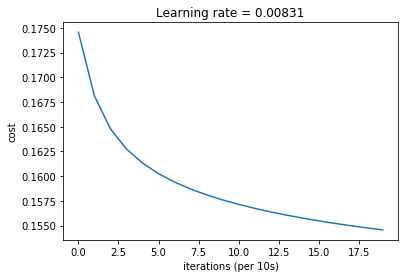

In [52]:
parameters = model(x_train, y_train, layer_dims,  
                   learning_rate = 0.00831, 
                   epochs = 100) 

In [53]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 4.25718290119131 %
Testing accuracy: 5.2521008403361344 %


#### Model with Learning Rate Decay

In [54]:
def model_decay(X, Y, layer_dims, learning_rate, epochs, decay, alpha_zero, print_cost = True):
    
    costs = []
    #t = 0
    
    parameters = init_params(layer_dims)
    #v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):

        AL, caches = forwardpass(X, parameters)
        cost = compute_cost(Y, AL) 
        grads = backwardpass(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        #t = t + 1
        #parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                 #beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.169312
Cost after iteration 10: 0.161893
Cost after iteration 20: 0.159152
Cost after iteration 30: 0.157802
Cost after iteration 40: 0.156990
Cost after iteration 50: 0.156441
Cost after iteration 60: 0.156038
Cost after iteration 70: 0.155727
Cost after iteration 80: 0.155478
Cost after iteration 90: 0.155271


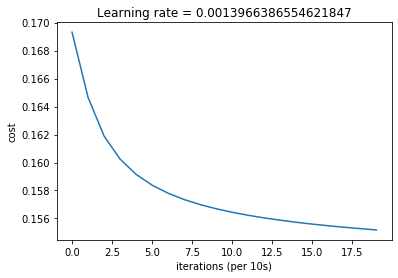

In [56]:
parameters = model_decay(x_train, y_train, layer_dims, 
                   decay = 0.05, 
                   alpha_zero = 0.00831, 
                   learning_rate = 0.00831, 
                   epochs = 100) 

In [57]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 5.956552207428171 %
Testing accuracy: 4.971988795518207 %


#### Model with L2 Regularization

In [100]:
def model_l2(X, Y, layer_dims, learning_rate, epochs, lambd, print_cost = True):
    
    costs = []
    #t = 0
    
    parameters = init_params(layer_dims)
    #v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):

        AL, caches = forwardpass(X, parameters)
        cost = compute_cost_l2(Y, AL, parameters, lambd) 
        grads = backwardpass_l2(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        #t = t + 1
        #parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                 #beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.163977
Cost after iteration 10: 0.163169
Cost after iteration 20: 0.162659
Cost after iteration 30: 0.162304
Cost after iteration 40: 0.162038
Cost after iteration 50: 0.161827
Cost after iteration 60: 0.161655
Cost after iteration 70: 0.161509
Cost after iteration 80: 0.161384
Cost after iteration 90: 0.161274


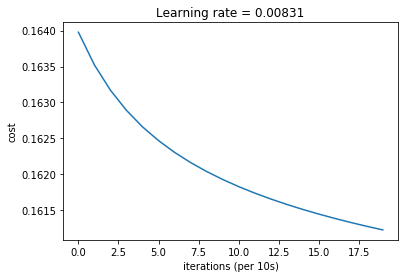

In [69]:
parameters = model_l2(x_train, y_train, layer_dims, 
                      lambd = 0.72,
                      learning_rate = 0.00831, 
                      epochs = 100, 
                      print_cost=True)

In [70]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")


Training accuracy: 6.131744919411353 %
Testing accuracy: 6.372549019607843 %


#### Model with Adam Optimizer

In [60]:
def model_adam(X, Y, layer_dims, learning_rate, epochs, print_cost = True):
    
    costs = []
    t = 0
    
    parameters = init_params(layer_dims)
    v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):

        AL, caches = forwardpass(X, parameters)
        cost = compute_cost(Y, AL) 
        grads = backwardpass(AL, Y, caches)
        #parameters = update_parameters(parameters, grads, learning_rate)
        t = t + 1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                 beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.158513
Cost after iteration 10: 0.149363
Cost after iteration 20: 0.148974
Cost after iteration 30: 0.148512
Cost after iteration 40: 0.147732
Cost after iteration 50: 0.146772
Cost after iteration 60: 0.145967
Cost after iteration 70: 0.144842
Cost after iteration 80: 0.143572
Cost after iteration 90: 0.143321


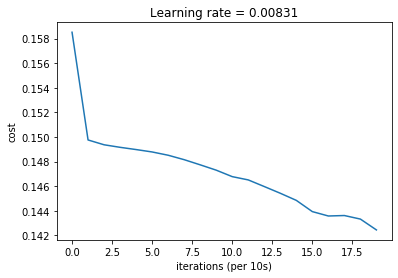

In [62]:
parameters = model_adam(x_train, y_train, layer_dims, 
                   learning_rate = 0.00831,   
                   epochs = 100, 
                   print_cost=True)

In [67]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 9.56552207428171 %
Testing accuracy: 8.123249299719888 %


#### Model with Adam Optimization and L2 Regulaization 

In [101]:
def model_adam_l2(X, Y, layer_dims, learning_rate, epochs, lambd, print_cost = True):
    
    costs = []
    t = 0
    
    parameters = init_params(layer_dims)
    v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):

        AL, caches = forwardpass(X, parameters)
        cost = compute_cost_l2(Y, AL, parameters, lambd) 
        grads = backwardpass_l2(AL, Y, caches)
        #parameters = update_parameters(parameters, grads, learning_rate)
        t = t + 1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, 
                                                       beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.173082
Cost after iteration 10: 0.201907
Cost after iteration 20: 0.219965
Cost after iteration 30: 0.222109
Cost after iteration 40: 0.217338
Cost after iteration 50: 0.210286
Cost after iteration 60: 0.202444
Cost after iteration 70: 0.195853
Cost after iteration 80: 0.190329
Cost after iteration 90: 0.184737


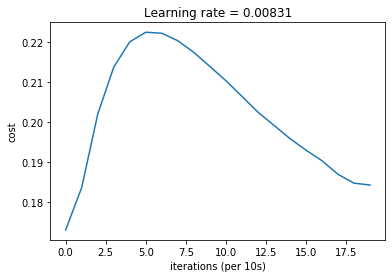

In [82]:
parameters = model_adam_l2(x_train, y_train, layer_dims, 
                      lambd = 0.72,
                      learning_rate = 0.00831, 
                      epochs = 100, 
                      print_cost=True)

In [83]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 10.68675543097407 %
Testing accuracy: 10.92436974789916 %


#### Model with Dropout Regularization

In [102]:
def model_dropout(X, Y, layer_dims, keep_prob, learning_rate, epochs, print_cost = True):
    
    costs = []
    #t = 0
    
    parameters = init_params(layer_dims)
    #v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):
        
        D = drop_out_matrices(layer_dims, m, keep_prob)
        AL, caches = forwardpass_dropout(X, parameters, D, keep_prob)
        cost = compute_cost(Y, AL) 
        grads = backwardpass_dropout(AL, Y, D, keep_prob, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        #t = t + 1
        #parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                 #beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.169138
Cost after iteration 10: 0.162101
Cost after iteration 20: 0.159519
Cost after iteration 30: 0.157980
Cost after iteration 40: 0.157267
Cost after iteration 50: 0.156665
Cost after iteration 60: 0.156289
Cost after iteration 70: 0.155904
Cost after iteration 80: 0.155751
Cost after iteration 90: 0.155287


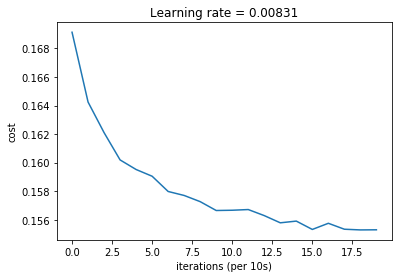

In [103]:
parameters = model_dropout(x_train, y_train, layer_dims, keep_prob, #keep_prob = [1, 0.5, 0.8, 1] 
                           learning_rate = 0.00831, 
                           epochs = 100,
                           print_cost=True)

In [105]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 4.152067274001402 %
Testing accuracy: 4.69187675070028 %


#### Model with Adam and Dropout Regularization

In [88]:
def model_adam_dropout(X, Y, layer_dims, keep_prob, learning_rate, epochs, print_cost = True):
    
    costs = []
    t = 0
    
    parameters = init_params(layer_dims)
    v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):
        
        D = drop_out_matrices(layer_dims, m, keep_prob)
        AL, caches = forwardpass_dropout(X, parameters, D, keep_prob)
        cost = compute_cost(Y, AL) 
        grads = backwardpass_dropout(AL, Y, D, keep_prob, caches)
        #parameters = update_parameters(parameters, grads, learning_rate)
        t = t + 1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, 
                                                       beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.176454
Cost after iteration 10: 0.149719
Cost after iteration 20: 0.149387
Cost after iteration 30: 0.149257
Cost after iteration 40: 0.149183
Cost after iteration 50: 0.149112
Cost after iteration 60: 0.149008
Cost after iteration 70: 0.148817
Cost after iteration 80: 0.148481
Cost after iteration 90: 0.148093


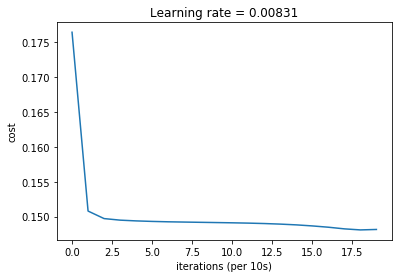

In [89]:
parameters = model_adam_dropout(x_train, y_train, layer_dims, keep_prob, #keep_prob = [1, 0.5, 0.8, 1] 
                               learning_rate = 0.00831, 
                               epochs = 100,
                               print_cost=True)

In [90]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 7.725998598458304 %
Testing accuracy: 8.26330532212885 %


#### Model with Adam, L2 and Dropout Regularization

In [106]:
def model_adam_l2_dropout(X, Y, layer_dims, keep_prob, learning_rate, lambd, epochs, print_cost = True):
    
    costs = []
    t = 0
    
    parameters = init_params(layer_dims)
    v, s = initialize_adam(parameters)
    
    
    for i in range(epochs):
        
        D = drop_out_matrices(layer_dims, m, keep_prob)
        AL, caches = forwardpass(X, parameters)
        cost = compute_cost_l2(Y, AL, parameters, lambd) 
        grads = backwardpass_dropout_l2(AL, Y, D, keep_prob, caches)
        #parameters = update_parameters(parameters, grads, learning_rate)
        t = t + 1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, 
                                                       beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        #learning_rate = alpha_zero/(1+decay*i)

        if print_cost and i % 10 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if i % 5 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10s)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.174650
Cost after iteration 10: 0.202914
Cost after iteration 20: 0.223139
Cost after iteration 30: 0.227261
Cost after iteration 40: 0.224162
Cost after iteration 50: 0.218147
Cost after iteration 60: 0.211609
Cost after iteration 70: 0.205157
Cost after iteration 80: 0.199403
Cost after iteration 90: 0.193516


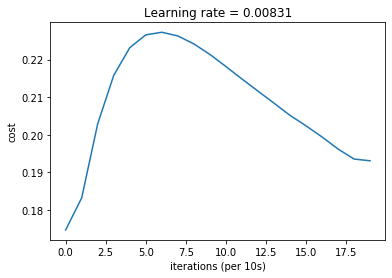

In [107]:
parameters = model_adam_l2_dropout(x_train, y_train, layer_dims, keep_prob, #keep_prob = [1, 0.5, 0.8, 1] 
                                   lambd = 0.72, 
                                   learning_rate = 0.00831, 
                                   epochs = 100,
                                   print_cost=True)

In [108]:
y_hat, y_label = make_pred(x_train, y_train)
score = accuracy_score(y_label, y_hat)
print("Training accuracy: " + str(score * 100) + " %")

y_hat, y_label = make_pred(x_test, y_test)
score = accuracy_score(y_label, y_hat)
print("Testing accuracy: " + str(score * 100) + " %")

Training accuracy: 10.634197617379117 %
Testing accuracy: 11.484593837535014 %


### --------------ROUGH WORK-------------

In [3]:
for i in range (2000):
    rate = 0.0034/(1+0.0008*i)
    print(str(i) + "----" + str(rate))

0----0.0034
1----0.003397282174260592
2----0.0033945686900958465
3----0.0033918595371109335
4----0.0033891547049441782
5----0.003386454183266932
6----0.0033837579617834396
7----0.0033810660302307075
8----0.003378378378378378
9----0.0033756949960285936
10----0.0033730158730158727
11----0.0033703409992069788
12----0.003367670364500792
13----0.0033650039588281866
14----0.003362341772151898
15----0.003359683794466403
16----0.0033570300157977884
17----0.0033543804262036302
18----0.0033517350157728706
19----0.003349093774625689
20----0.0033464566929133858
21----0.0033438237608182536
22----0.003341194968553459
23----0.0033385703063629223
24----0.0033359497645211924
25----0.003333333333333333
26----0.0033307210031347963
27----0.003328112764291307
28----0.003325508607198748
29----0.003322908522283033
30----0.0033203125
31----0.003317720530835285
32----0.003315132605304212
33----0.003312548713951676
34----0.0033099688473520244
35----0.003307392996108949
36----0.0033048211508553654
37----0.003302